In [10]:
# %matplotlib widget

import os
import pandas as pd
import numpy as np
import librosa
from librosa import display
import matplotlib.pyplot as plt
import seaborn as sns
import wave
import contextlib

# 1. Preprocessing


In [11]:
ravdess_data = "data/RAVDESS/Speech/"

In [12]:
def extract_labels(file_name:str)->int:
    parts = file_name.split('-')
    emotion = int(parts[2])  # Emotion is the third part
    return emotion

def label_to_emotion(label:int)->str:
    if label == 1:
        return "neutral"
    elif label == 2:
        return "calm"
    elif label == 3:
        return "happy"
    elif label == 4:
        return "sad"
    elif label == 5:
        return "angry"
    elif label == 6:
        return "fearful"
    elif label == 7:
        return "disgust"
    elif label == 8:
        return "surprised"
    else:
        return "unknown"

def create_dataframe(directory:str)->pd.DataFrame:
    data = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                label = extract_labels(file)
                emotion = label_to_emotion(label)
                data.append({"FilePath": file_path, "Emotion": emotion, "Label": label})
    df = pd.DataFrame(data)
    return df

In [13]:
dataframe = create_dataframe(ravdess_data)

In [5]:
dataframe.head()

,FilePath,Emotion,Label
0,data/RAVDESS/Speech/Actor_16/03-01-05-01-02-01...,angry,5
1,data/RAVDESS/Speech/Actor_16/03-01-06-01-02-02...,fearful,6
2,data/RAVDESS/Speech/Actor_16/03-01-06-02-01-02...,fearful,6
3,data/RAVDESS/Speech/Actor_16/03-01-05-02-01-01...,angry,5
4,data/RAVDESS/Speech/Actor_16/03-01-07-01-01-01...,disgust,7


In [6]:
print(dataframe.Emotion.value_counts())


Emotion
angry        192
fearful      192
disgust      192
sad          192
surprised    192
happy        192
calm         192
neutral       96
Name: count, dtype: int64


# 2. Data Visualisation and Exploration

In [7]:
dataframe.count()

FilePath    1440
Emotion     1440
Label       1440
dtype: int64

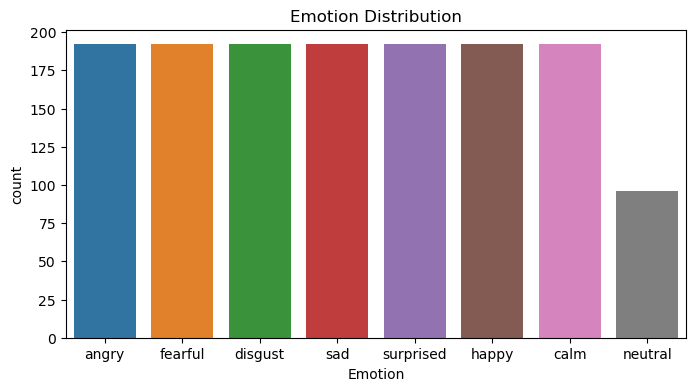

In [8]:
plt.figure(figsize=(8, 4))
sns.countplot(data=dataframe, x="Emotion")
plt.title("Emotion Distribution")
plt.show()

**Check the sampling rate of one random file to make sure it is the same as the one mentioned on the database website.**

In [19]:
sampling_rate = 0
with contextlib.closing(wave.open(dataframe.FilePath[6], 'r')) as wav_file:
    sampling_rate = wav_file.getframerate()
    print(f"Sampling rate: {sampling_rate} Hz")

Sampling rate: 48000 Hz


In [20]:
def load_audio(file_path:str)-> np.ndarray:
    audio, _ = librosa.load(file_path, sr=sampling_rate)
    return audio

In [15]:
def plot_audio(audio:np.ndarray):
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(audio, sr=sampling_rate)
    plt.grid()
    plt.show()

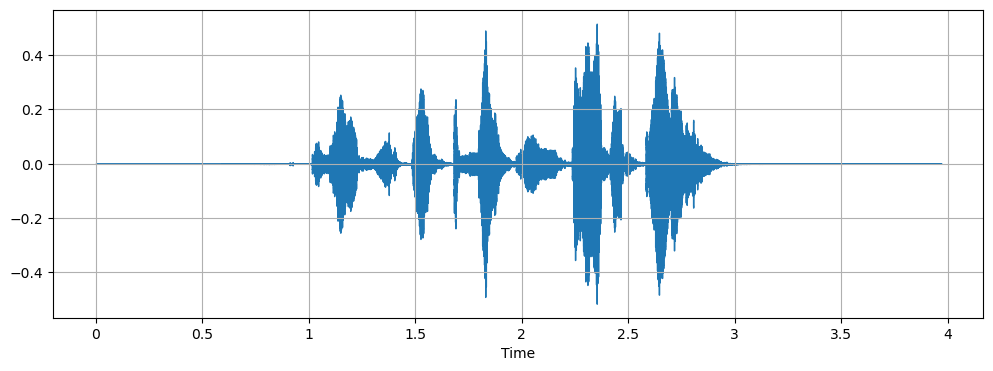

In [12]:
test_audio = load_audio(dataframe.FilePath[3])
plot_audio(test_audio)



# Data augmentation

In [16]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate:float=0.8):
    return librosa.effects.time_stretch(data, rate = rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor:bool=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [17]:
import numpy as np
import librosa

def augment_data(data, sampling_rate):
    augmentations = [
        lambda x: noise(x),
        lambda x: stretch(x, rate=np.random.uniform(0.8, 1.2)),
        lambda x: shift(x),
        lambda x: pitch(x, sampling_rate, pitch_factor=np.random.uniform(0.5, 1.5))
    ]
    augmented_data = data
    for augmentation in augmentations:
        if np.random.rand() < 0.5:  # Apply each augmentation with 50% probability
            augmented_data = augmentation(augmented_data)
    return augmented_data


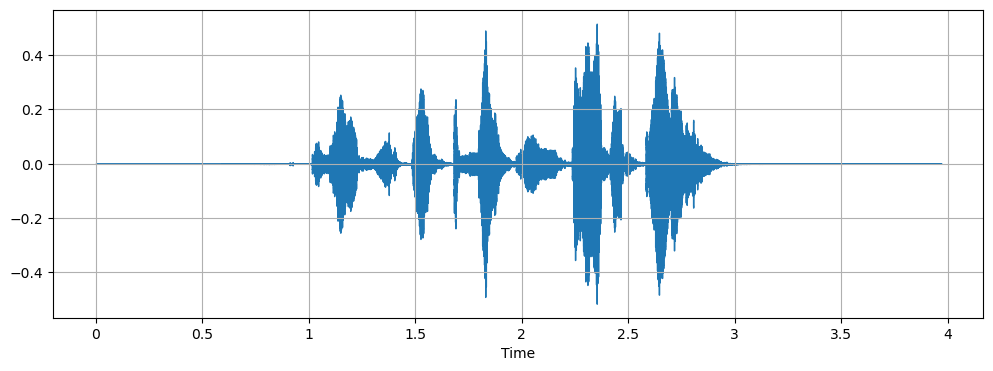

In [21]:
import IPython.display as ipd
from IPython.display import Audio

test = load_audio(dataframe.FilePath[3])
plot_audio(test)
ipd.Audio(test,rate=sampling_rate)


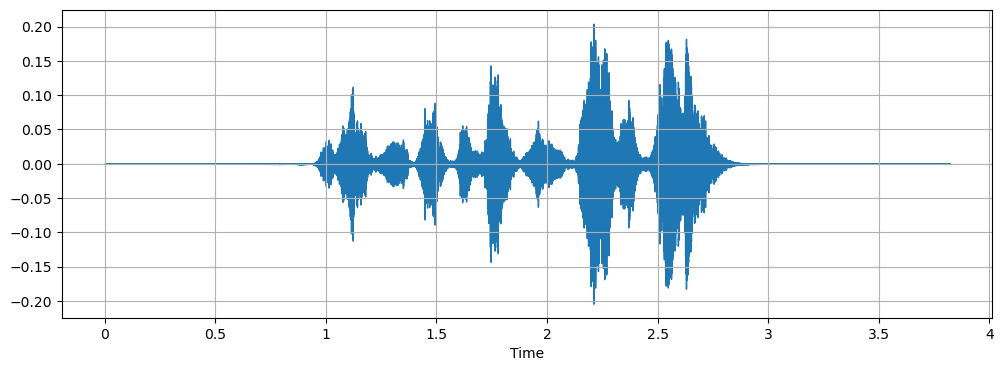

In [21]:
augmented_test = augment_data(test, sampling_rate)
plot_audio(augmented_test)
ipd.Audio(augmented_test,rate=sampling_rate)

# 3. Feature Extraction

### 3.1 Mel-Frequency Cepstral Coefficients (MFCCs)

In [22]:
def extract_mfcc(audio_path:str, sr:float=48000, n_mfcc:int=40,show_plot:bool=False,data:np.ndarray=None)->np.ndarray:
    audio = load_audio(audio_path) if data is None else data
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    if show_plot:
        librosa.display.specshow(mfcc, x_axis='time')
        plt.ylabel('MFCC')
        plt.colorbar()  
    return np.mean(mfcc.T, axis=0) 

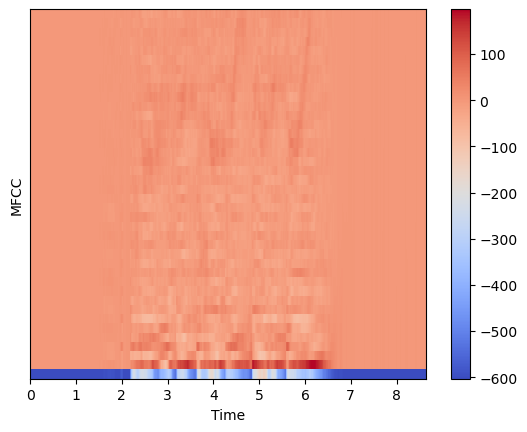

In [23]:
mfcc = extract_mfcc(dataframe.FilePath[3],show_plot=True)


In [15]:
mfcc.shape

(40,)

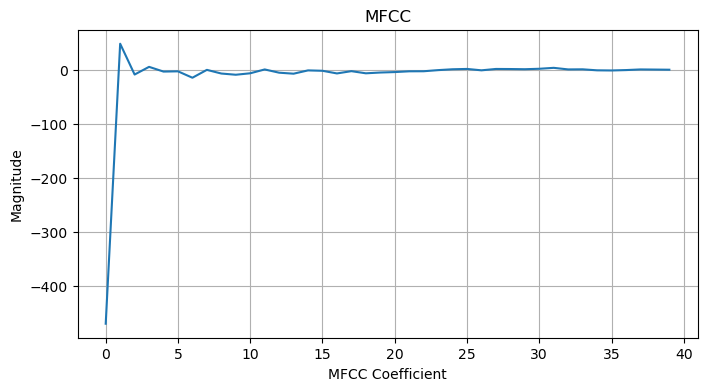

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(mfcc)
plt.title("MFCC")
plt.xlabel("MFCC Coefficient")
plt.ylabel("Magnitude")
plt.grid()
plt.show()

### 3.2 Log-Mel Spectrogram

In [24]:
def extract_logmel(audio_path:str, sr:float=48000, n_mels:int=128,show_plot:bool=False, data:np.ndarray=None)->np.ndarray:
    audio= load_audio(audio_path) if data is None else data
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    logmel = librosa.power_to_db(mel_spectrogram)
    if show_plot:
        plt.figure(figsize=(8, 4))
        librosa.display.specshow(logmel, y_axis='mel', sr=sampling_rate, x_axis='time');
        print(logmel.shape)
        plt.title('Mel Spectrogram ')
        plt.colorbar(format='%+2.0f dB')

    return logmel.mean(axis=1)  # Mean across time frames


(128, 373)
(128, 304)


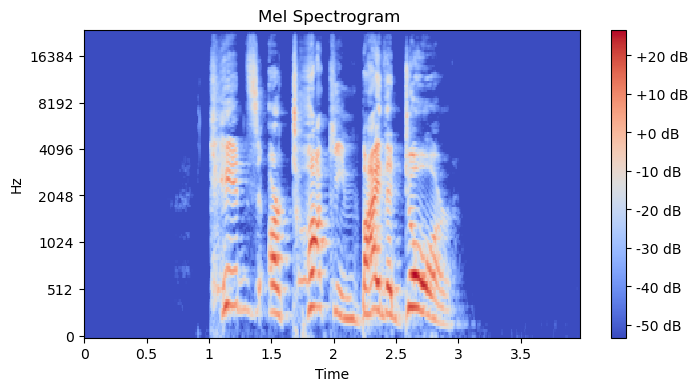

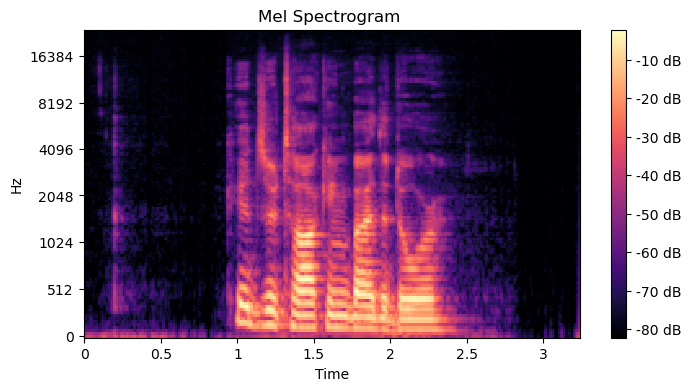

In [26]:
logmel = extract_logmel(dataframe.FilePath[3],show_plot=True)
logmel3 = extract_logmel(dataframe.FilePath[300],show_plot=True)

In [19]:
logmel.shape

(128,)

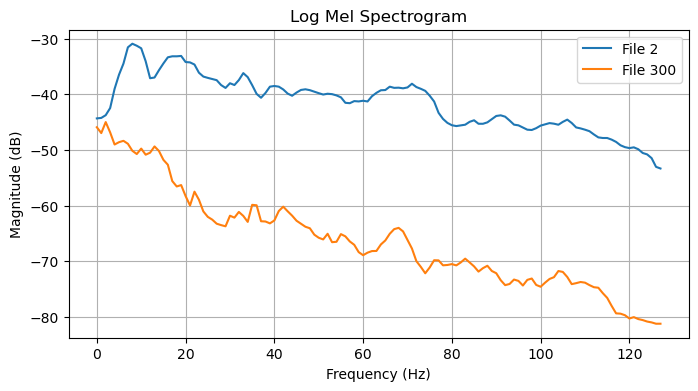

In [27]:
plt.figure(figsize=(8, 4))
plt.plot(logmel, label="File 2")
plt.plot(logmel3, label="File 300")
plt.title("Log Mel Spectrogram")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.grid()
plt.show()

### 3.3 Prosodic Features (Pitch, Intensity, Duration)

In [25]:
def extract_prosodic(audio_path:str, sr:float=48000, data:np.ndarray = None) -> list:
    audio =load_audio(audio_path) if data is None else data
    # Pitch (F0)
    pitches = librosa.yin(audio, fmin=50, fmax=260)
    pitch_mean = pitches.mean()

    # Intensity (Energy)
    energy = np.sqrt(np.mean(audio**2))

    # Duration (Voiced regions)
    voiced_frames = librosa.effects.split(audio, top_db=35)
    duration = sum((v[1] - v[0]) for v in voiced_frames) / sr
    return [pitch_mean, energy, duration]


In [31]:
prosodic_features = extract_prosodic(dataframe.FilePath[3])

print(f"Pitch: {prosodic_features[0]:.2f} Hz")
print(f"Energy: {prosodic_features[1]:.2f}")
print(f"Duration: {prosodic_features[2]:.2f} seconds")

Pitch: 154.56 Hz
Energy: 0.05
Duration: 1.90 seconds


In [30]:
prosodic_features = extract_prosodic(dataframe.FilePath[300])

print(f"Pitch: {prosodic_features[0]:.2f} Hz")
print(f"Energy: {prosodic_features[1]:.2f}")
print(f"Duration: {prosodic_features[2]:.2f} seconds")

Pitch: 146.59 Hz
Energy: 0.00
Duration: 1.56 seconds


### 3.4 Features combination

In [32]:
def extract_features_from_dataset(dataset:pd.DataFrame, output_pickle:str):
    if "FilePath" not in dataset.columns:
        raise ValueError("Dataset must have a 'FilePath' column containing file paths.")

    data = []
    for file_path in dataset.FilePath:
            if file_path.endswith(".wav"):
                try:
                    mfcc = extract_mfcc(file_path)
                    logmel = extract_logmel(file_path)
                    prosodic = extract_prosodic(file_path)
                    # Combine features
                    features = np.hstack([mfcc, logmel, prosodic])
                    data.append(features)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
                    data.append(None)
                    continue
    dataset["Features"] = data    
    # Save to pickle
    os.makedirs(output_pickle, exist_ok=True)
    output_pickle = f"{output_pickle}/RAVDESS.pkl"
    dataset.to_pickle(output_pickle)
    print(f"Features extracted and saved to {output_pickle}")


In [26]:
import numpy as np
import librosa

def extract_features(path:str = None,data:np.ndarray = None)->np.ndarray:
    # Extract MFCCs
    mfcc = extract_mfcc(audio_path= path,data=data)
    
    # Extract log mel spectrogram
    logmel = extract_logmel(audio_path = path,data=data)
    
    # Extract prosodic features
    parasodic = extract_prosodic(audio_path = path,data=data)
    
    # Combine features
    features = np.hstack([mfcc, logmel, parasodic])
    
    return features

def get_features(path,augment=True):
    # Load the audio file
    data = load_audio(path)
    
    # Extract original features
    features = [extract_features(path,None)]
    
    if augment:
        # Apply augmentations
        augmentations = [
            lambda x: noise(x),  # Add noise
            lambda x: pitch(x, sampling_rate, pitch_factor=np.random.uniform(0.5, 1.5)),  # Random pitch shift
        ]

        for aug in augmentations:
            augmented_audio = aug(data)
            features.append(extract_features(data=augmented_audio))
        
        combined_features = extract_features(data=noise(augmentations[1](data)))
        features.append(combined_features)
        

    audio=np.vstack((features))
    
    return audio


In [32]:
sample1 = get_features(dataframe.FilePath[200])
sample1.shape
DUMMY = pd.DataFrame(columns=["Feature","Emotion"])
features = []
labels = []
for item in sample1:
    features.append(item)
    labels.append(dataframe.Emotion[200])
sample2 = get_features(dataframe.FilePath[3])
sample2.shape
for item in sample2:
    features.append(item)
    labels.append(dataframe.Emotion[3])
DUMMY["Feature"] = features
DUMMY["Emotion"] = labels

DUMMY.head()

,Feature,Emotion
0,"[-612.8169555664062, 58.136962890625, -15.0666...",surprised
1,"[-388.8256325016511, 16.31751651450574, -0.679...",surprised
2,"[-652.7055053710938, 54.621559143066406, -15.4...",surprised
3,"[-430.8907527847113, 15.630939523683528, -1.86...",surprised
4,"[-470.210693359375, 48.58982467651367, -8.5055...",angry


In [34]:
DUMMY.Feature[0].shape

(171,)

In [36]:
from tqdm import tqdm

def extract_features_and_augment_from_dataset(dataset:pd.DataFrame, output_pickle:str):
    if "FilePath" not in dataset.columns:
        raise ValueError("Dataset must have a 'FilePath' column containing file paths.")

    X = []
    Y = []
    for file_path in tqdm(dataset.FilePath):
            if file_path.endswith(".wav"):
                try:
                    features = get_features(file_path)
                    for item in features:
                        X.append(item)
                        Y.append(extract_labels(file_path))
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
                    X.append(None)
                    Y.append(None)
                    continue
    DATA = pd.DataFrame(columns=["Feature","Emotion"])
    DATA['Feature'] = X
    DATA['Emotion'] = Y
    # Save to pickle
    os.makedirs(output_pickle, exist_ok=True)
    output_pickle = f"{output_pickle}/RAVDESS_AUG.pkl"
    DATA.to_pickle(output_pickle)
    print(f"Features extracted and saved to {output_pickle}")

In [37]:
output_pickle_folder = "data/pickle/"
# extract_features_from_dataset(dataframe, output_pickle_folder)
extract_features_and_augment_from_dataset(dataframe, output_pickle_folder)

100%|██████████| 1440/1440 [05:34<00:00,  4.31it/s]


Features extracted and saved to data/pickle//RAVDESS_AUG.pkl


# 4. Feature space visualization

### 4.1 Normalization

In [42]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd

pick_file = "data/pickle/RAVDESS_AUG.pkl"

DATASET = pd.read_pickle(pick_file)

DATASET.head()

print(f"Original shape: {DATASET.Feature.shape}")
scaler = MinMaxScaler()

DATASET.Feature =  scaler.fit_transform(np.array(DATASET.Feature.tolist())).tolist()

print(f"Normalized shape: {DATASET.Feature.shape}")


Original shape: (5760,)
Normalized shape: (5760,)


In [43]:
DATASET.head()

,Feature,Emotion
0,"[0.4426577386169729, 0.41328240275243244, 0.62...",5
1,"[0.7572970595947013, 0.08363765296271672, 0.73...",5
2,"[0.4174753923824174, 0.3700181904874069, 0.617...",5
3,"[0.7196826447162461, 0.08307823646425126, 0.72...",5
4,"[0.4172628506511068, 0.4507283500981357, 0.625...",6


### 4.2 k-means Clustring

#### 4.2.1 Compute PCA and then clustering

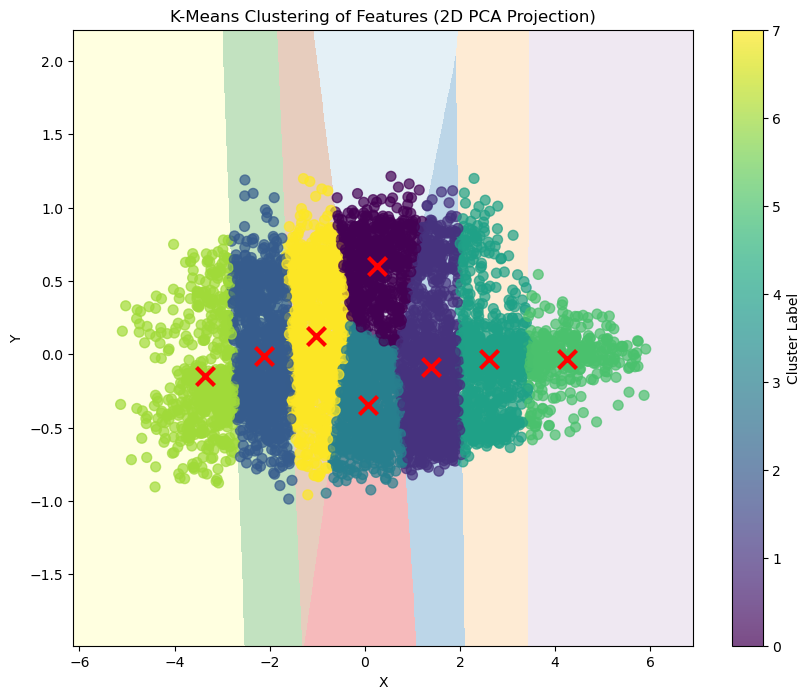

In [46]:
normalized_features = DATASET.Feature.tolist()
n_clusters = 8  

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(normalized_features)

DATASET["PCA"] = reduced_features.tolist()

kmeans = KMeans(n_clusters=n_clusters,random_state=42,n_init=100,init='k-means++')
kmeans.fit(reduced_features)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.01 # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_features[:, 0].min() - 1, reduced_features[:, 0].max() + 1
y_min, y_max = reduced_features[:, 1].min() - 1, reduced_features[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Fit k-means to the normalized features
cluster_labels = kmeans.fit_predict(reduced_features)

DATASET["Cluster"] = cluster_labels

plt.figure(figsize=(10, 8))
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower', alpha=0.3)
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=50,alpha=0.7)
plt.colorbar(scatter, label="Cluster Label")
plt.title("K-Means Clustering of Features (2D PCA Projection)")
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="r",
    zorder=10,
)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

#### 4.2.2Compute the most frequent emotion in each cluster

In [47]:
cluster_to_emotion = DATASET.groupby('Cluster')['Emotion'].agg(lambda x: x.value_counts().idxmax())

DATASET["PredictedEmotion"] = DATASET.Cluster.map(cluster_to_emotion)


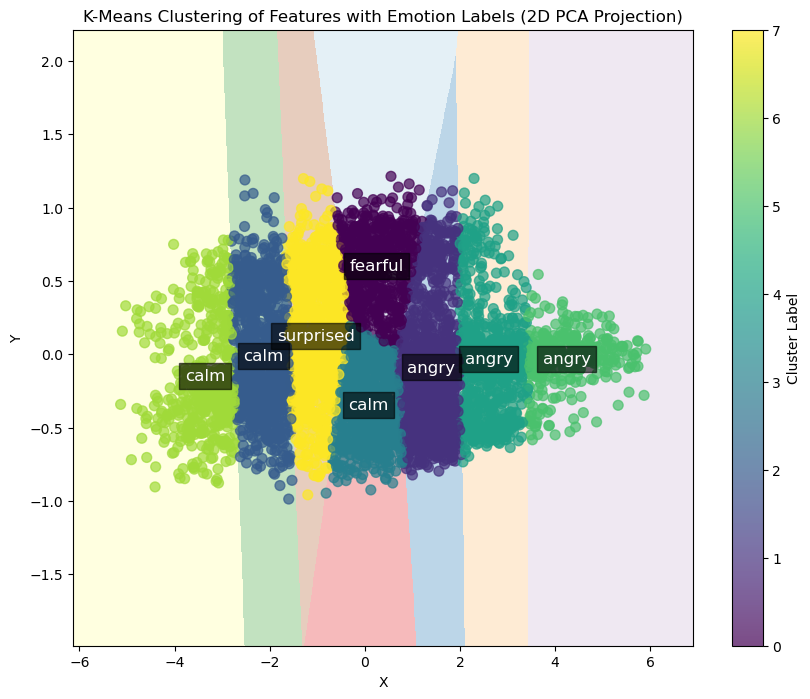

In [50]:
plt.figure(figsize=(10, 8))
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower', alpha=0.3)
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='viridis', s=50,alpha=0.7,)
plt.colorbar(scatter, label="Cluster Label")
# Add cluster names
cluster_names = list(cluster_to_emotion.values)  
for i, name in enumerate(cluster_names):
    plt.text(
        centroids[i, 0],  # X coordinate of the centroid
        centroids[i, 1],  # Y coordinate of the centroid
        label_to_emotion(name),  # The name of the cluster
        fontsize=12,
        ha='center',  # Horizontal alignment
        va='center',  # Vertical alignment
        color='white',
        bbox=dict(facecolor='black', alpha=0.6)  # Background box for better visibility
    )
plt.title("K-Means Clustering of Features with Emotion Labels (2D PCA Projection)")

plt.xlabel("X")

plt.ylabel("Y")
plt.show()

# 5. Prepare Dataset and Train the Model

In [51]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
import torch.nn.functional as F



pickle_file = "data/pickle/RAVDESS_AUG.pkl"

# Device configuration
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)


mps


### 5.1 Custom Dataset 

#### 5.1.1 Dataset class

In [64]:
class AudioEmotionDataset(Dataset):
    def __init__(self,pick_file:str,transform=None):
        self.data = pd.read_pickle(pick_file)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        features = self.data.Feature[index]
        label = self.data.Emotion[index] - 1 # Labels are 1-8, convert to 0-7
        if self.transform:
            features = self.transform(features)
        
        return features.unsqueeze(0), label

#### 5.1.2 Normalization & transform function

In [65]:
from torchvision import transforms


def normalization(tensor:torch.Tensor)->torch.Tensor:
    min_val = tensor.min()
    max_val = tensor.max()
    return (tensor - min_val) / (max_val - min_val)

def to_tensor(array:np.ndarray)->torch.Tensor:
    return torch.from_numpy(array).float()

transforms = transforms.Compose(
    [
    to_tensor,
    normalization
    ]
)

dataset = AudioEmotionDataset(pickle_file, transform=transforms)

In [66]:
dataset.data.head()

,Feature,Emotion
0,"[-563.2865600585938, 49.64883804321289, -6.105...",5
1,"[-326.287221718707, 12.860897523536998, 1.8969...",5
2,"[-582.2549438476562, 44.82060623168945, -6.833...",5
3,"[-354.61995333830913, 12.798467344125978, 1.56...",5
4,"[-582.4150390625, 53.8277587890625, -6.2177357...",6


### 5.2 Split data to Train, Validation, Test 

In [67]:
train_size = int(0.7*dataset.__len__())
val_size = int(0.2*dataset.__len__())
test_size = dataset.__len__() - train_size - val_size

train_data, test_data,val_data  = random_split(dataset, [train_size, test_size, val_size])
len(train_data), len(test_data), len(val_data)



(4031, 577, 1152)

### 5.3 DataLoader

In [68]:
batch_size = 34

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)



In [70]:
example_batch_feature, example_batch_label = next(iter(train_loader))

print(f"Batch inputs shape: {example_batch_feature[0].shape}")
print(f"Batch label shape: {example_batch_label[0].shape}")

Batch inputs shape: torch.Size([1, 171])
Batch label shape: torch.Size([])


(tensor(0), tensor(7))

In [71]:
example_batch_feature[0].shape , example_batch_label[0]

(torch.Size([1, 171]), tensor(2))

In [72]:
example_batch_feature[0].size()

torch.Size([1, 171])

### 5.4 UNet model

In [87]:
class UNet(nn.Module):
    def __init__(self, num_classes=8, threshold_value=0.5):
        super(UNet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(1, 16)
        self.down_conv_2 = double_conv(16, 32)
        self.down_conv_3 = double_conv(32, 64)
        self.down_conv_4 = double_conv(64, 128)

        self.up_trans_1 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.up_conv_1 = double_conv(128, 64)
        
        self.up_trans_2 = nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2)
        self.up_conv_2 = double_conv(64, 32)

        self.up_trans_3 = nn.ConvTranspose1d(32, 16, kernel_size=2, stride=2)
        self.up_conv_3 = double_conv(32, 16)

        self.out = nn.Conv1d(16, num_classes, kernel_size=1)  # Output for 8 classes
        self.threshold_value = threshold_value

    def forward(self, image):
        # Encoder
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)



        # Decoder
        x = self.up_trans_1(x7)
        if x.size() != x5.size():
            diff = x5.size(2) - x.size(2)
            x = F.pad(x, [diff // 2, diff - diff // 2])
        x = self.up_conv_1(torch.cat([x, x5], 1))

        x = self.up_trans_2(x)
        if x.size() != x3.size():
            diff = x3.size(2) - x.size(2)
            x = F.pad(x, [diff // 2, diff - diff // 2])
        x = self.up_conv_2(torch.cat([x, x3], 1))
        
        x = self.up_trans_3(x)
        if x.size() != x1.size():
            diff = x1.size(2) - x.size(2)
            x = F.pad(x, [diff // 2, diff - diff // 2])
        x = self.up_conv_3(torch.cat([x, x1], 1))

        # Output layer
        x = self.out(x)  # Shape: [batch_size, num_classes, seq_length]
        x = torch.mean(x, dim=2)  # Global average pooling: [batch_size, num_classes]
        x = F.softmax(x, dim=1)  # Class probabilities
        return x

# Define the double_conv function
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm1d(out_channels, track_running_stats=False),
        nn.ReLU(inplace=True),
        nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm1d(out_channels, track_running_stats=False),
        nn.ReLU(inplace=True),
    )

In [86]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0

        for features, labels in train_loader:
            # Move data to GPU if available
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")
        

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return all_predictions, all_labels

In [89]:
# Initialize model, loss function, and optimizer
model = UNet(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=100)

# Test the model
predictions, ground_truth = test_model(model, test_loader)

Epoch [10/100], Loss: 1.9936, Accuracy: 0.2553
Epoch [20/100], Loss: 1.9915, Accuracy: 0.2563
Epoch [30/100], Loss: 1.9898, Accuracy: 0.2543
Epoch [40/100], Loss: 1.9914, Accuracy: 0.2553
Epoch [50/100], Loss: 1.9892, Accuracy: 0.2493
Epoch [60/100], Loss: 1.9898, Accuracy: 0.2533
Epoch [70/100], Loss: 1.9871, Accuracy: 0.2600
Epoch [80/100], Loss: 1.9861, Accuracy: 0.2600
Epoch [90/100], Loss: 1.9803, Accuracy: 0.2702
Epoch [100/100], Loss: 1.9766, Accuracy: 0.2736
Test Accuracy: 0.2721


In [ ]:
# Plot the loss and accuracy curves

plt.figure(figsize=(12, 4))
plt.plot(total_loss, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(accuracies, label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.grid()
plt.legend()
plt.show()

### 5.5 CNN Model

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AudioEmotionModel1(nn.Module):
    def __init__(self, input_length, num_classes=7):
        super(AudioEmotionModel1, self).__init__()
        
        # First block
        self.conv1 = nn.Conv1d(1, 512, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(512)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        
        # Second block
        self.conv2 = nn.Conv1d(512, 512, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(512)
        self.pool2 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.dropout1 = nn.Dropout(0.2)
        
        # Third block
        self.conv3 = nn.Conv1d(512, 256, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        
        # Fourth block
        self.conv4 = nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        self.dropout2 = nn.Dropout(0.2)
        
        # Fifth block
        self.conv5 = nn.Conv1d(256, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm1d(128)
        self.pool5 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.dropout3 = nn.Dropout(0.2)
        
        # Fully connected layers
        self.flatten_length = self._calculate_flatten_size(input_length)
        self.fc1 = nn.Linear(self.flatten_length, 512)
        self.bn6 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, num_classes)

    def _calculate_flatten_size(self, input_length):
        # Calculate the flattened size after all convolution and pooling layers
        with torch.no_grad():
            x = torch.zeros(1, 1, input_length)  # Dummy input
            x = self.pool1(self.bn1(F.relu(self.conv1(x))))
            x = self.pool2(self.bn2(F.relu(self.conv2(x))))
            x = self.pool3(self.bn3(F.relu(self.conv3(x))))
            x = self.pool4(self.bn4(F.relu(self.conv4(x))))
            x = self.pool5(self.bn5(F.relu(self.conv5(x))))
        return x.numel()

    def forward(self, x):
        # Convolutional blocks
        x = self.pool1(self.bn1(F.relu(self.conv1(x))))
        x = self.pool2(self.bn2(F.relu(self.conv2(x))))
        x = self.dropout1(x)
        x = self.pool3(self.bn3(F.relu(self.conv3(x))))
        x = self.pool4(self.bn4(F.relu(self.conv4(x))))
        x = self.dropout2(x)
        x = self.pool5(self.bn5(F.relu(self.conv5(x))))
        x = self.dropout3(x)
        
        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.bn6(self.fc1(x)))
        x = self.fc2(x)
        return F.softmax(x, dim=1)  # Class probabilities

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AudioEmotionModel2(nn.Module):
    def __init__(self, input_length, num_classes):
        super(AudioEmotionModel2, self).__init__()
        
        # First block
        self.conv1 = nn.Conv1d(1, 256, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        
        # Second block
        self.conv2 = nn.Conv1d(256, 128, kernel_size=5, padding=2)
        self.dropout1 = nn.Dropout(0.1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(kernel_size=8, stride=8, padding=0)
        
        # Third block
        self.conv3 = nn.Conv1d(128, 128, kernel_size=5, padding=2)
        self.conv4 = nn.Conv1d(128, 128, kernel_size=5, padding=2)
        self.conv5 = nn.Conv1d(128, 128, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.pool2 = nn.MaxPool1d(kernel_size=8, stride=8, padding=0)
        
        # Fourth block
        self.conv6 = nn.Conv1d(128, 128, kernel_size=5, padding=2)
        self.flatten = nn.Flatten()
        self.dropout3 = nn.Dropout(0.2)
        
        # Dense layer
        self.fc1 = nn.Linear((input_length // 64) * 128, num_classes)
        self.bn4 = nn.BatchNorm1d(num_classes)

    def forward(self, x):
        # First block
        x = self.relu1(self.bn1(self.conv1(x)))
        
        # Second block
        x = self.pool1(self.bn2(self.dropout1(F.relu(self.conv2(x)))))
        
        # Third block
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool2(self.bn3(self.dropout2(x)))
        
        # Fourth block
        x = F.relu(self.conv6(x))
        x = self.flatten(x)
        x = self.dropout3(x)
        
        # Dense layer
        x = self.fc1(x)
        x = self.bn4(x)
        return F.softmax(x, dim=1)  # Class probabilities

In [35]:
input_length = 171  # Replace with the length of your input sequences
num_classes = 8  # Number of classes in the dataset
model = AudioEmotionModel(input_length=input_length, num_classes=num_classes).to(device)

In [75]:
input_length = 171  # Replace with the length of your input sequences
num_classes = 8  # Number of classes in the dataset
model = AudioEmotionModel2(input_length=input_length, num_classes=num_classes).to(device)

In [76]:
next(iter(train_loader))[0].shape , train_data.__len__()

(torch.Size([34, 1, 171]), 4031)

In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [80]:
from tqdm import tqdm

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0

        for features, labels in tqdm(train_loader):
            # Move data to GPU if available
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")


def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)

            # Forward pass
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return all_predictions, all_labels

In [81]:
# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=50)

# Test the model
predictions, ground_truth = test_model(model, test_loader)

100%|██████████| 119/119 [00:01<00:00, 70.46it/s]


Epoch [10/50], Loss: 1.9827, Accuracy: 0.2682


100%|██████████| 119/119 [00:01<00:00, 75.33it/s]


Epoch [20/50], Loss: 1.9762, Accuracy: 0.2697


100%|██████████| 119/119 [00:01<00:00, 75.40it/s]


Epoch [30/50], Loss: 1.9669, Accuracy: 0.2870


100%|██████████| 119/119 [00:01<00:00, 77.06it/s]


Epoch [40/50], Loss: 1.9729, Accuracy: 0.2818


100%|██████████| 119/119 [00:01<00:00, 77.16it/s]


Epoch [50/50], Loss: 1.9424, Accuracy: 0.3220
Test Accuracy: 0.2929
